In [6]:
import os
import io
import json
from PIL import Image, ImageOps, ImageEnhance, ImageFilter

class DataAugmentation:
    def __init__(self, notation_file, training_folder, new_train_dataset):
        self.notation_file = notation_file
        self.training_folder = training_folder
        self.notation_list = []
        self.new_notation_list = []
        self.new_train_set_path = new_train_dataset
        if not os.path.isdir(self.new_train_set_path):
            os.mkdir(self.new_train_set_path)
            print("Creating new image set under {}".format(self.new_train_set_path))

    def load_notations(self):
        with io.open(self.notation_file,'r') as n:
            notation_content = n.readlines()

        for img_entry in notation_content:
            self.notation_list.append(json.loads(img_entry))

    def save_notations(self):
        with open(os.path.join('./all', 'all_label.idl'), 'w') as n:
            for item in self.new_notation_list:
                json_str = json.dumps(item)
                n.write(json_str + '\n')
        print("New Label Notation has been saved!")
    
    def image_split_middle(self, image, org_coordinate, image_size):
        left_image = image.crop((0,0,image_size['width']/2,image_size['height']))
        right_image = image.crop((image_size['width']/2,0, image_size['width'],image_size['height']))
        new_coordinate_left, new_coordinate_right = self.coordinate_split(org_coordinate, image_size)
        return [[left_image, new_coordinate_left], [right_image, new_coordinate_right]]
    
    def coordinate_split(self, org_cords, image_size):
        """
        split the notation coordinate from original to left half and right half
        :param image_size: original image size, Format {'width': 640, 'height':360}
        :param org_cords: Format of coordinate [[top_left_x, top_left_y, bottom_right_x, bottom_right_y, category],]
        :return: Transferred coordinates with same Format as input
        """
        new_cords = []
        new_cords_left = []
        new_cords_right = []
        middle = image_size['width']/2
        for cord in org_cords:
            if cord[0]<=middle<=cord[2]:
                new_cords_left.append([cord[0],cord[1], middle, cord[3], cord[4]])
                new_cords_right.append([0, cord[1], cord[2]-middle, cord[3], cord[4]])
            # all in left
            elif cord[2]<=middle:
                new_cords_left.append(cord)
            # all in right
            else:
                new_cords_right.append([cord[0]-middle, cord[1], cord[2]-middle, cord[3], cord[4]])   

        return [new_cords_left, new_cords_right]
                                       
    def image_transform_mirror(self, image, org_coordinate, image_size):
        mirror_img = ImageOps.mirror(image)
        new_coordinate = self.coordinate_transform(org_coordinate, image_size)
        return mirror_img, new_coordinate

    def coordinate_transform(self, org_cords, image_size):
        """
        Transform the notation coordinate from original to mirror image
        :param image_size: original image size, Format {'width': 640, 'height':360}
        :param org_cords: Format of coordinate [[top_left_x, top_left_y, bottom_right_x, bottom_right_y, category],]
        :return: Transferred coordinate with same Format as input
        """
        new_cords = []
        for cord in org_cords:
            top_left_x = image_size['width'] - cord[2]
            top_left_y = cord[1]
            bottom_right_x = image_size['width'] - cord[0]
            bottom_right_y = cord[3]
            new_cords.append([top_left_x, top_left_y, bottom_right_x, bottom_right_y, cord[4]])
        return new_cords



    def image_transform_blur(self, image):
        """
        generate two blur images for training set with Gaussian and MedianFilter
        :type image: image which loaded by PIL.Image.open
        :return: 2 blur images
        """
        blur_images = [image.filter(ImageFilter.GaussianBlur(1)),
                       image.filter(ImageFilter.MedianFilter(3  ))]
        return blur_images



    def new_training_set(self):
        # Image size for this project is 640*360
        image_size = {'width': 640, 'height': 360}
        for image_detail in self.notation_list:
            image_path = None
            notation = None
            image_name =None
            for key in image_detail.keys():
                image_name = key
                notation = image_detail[key]
            image_path = os.path.join(self.training_folder, image_name)
            print("Loading image {}".format(image_path))
            original_image = Image.open(image_path)
            mirror_image, new_notation = self.image_transform_mirror(original_image, notation, image_size)
            blur_images = self.image_transform_blur(original_image)
            split_images_with_notation = self.image_split_middle(original_image, notation, image_size)
            blur_mirror_images = self.image_transform_blur(mirror_image)
            blur_split_images_with_notation = []
            for image_i, notation_i in split_images_with_notation:
                results = self.image_transform_blur(image_i)
                blur_split_images_with_notation += list(map((lambda img: [img, notation_i]), results)) 
            
            split_mirror_images_with_notation = self.image_split_middle(mirror_image, new_notation, image_size)
            
            image_list = []

            image_list.append([original_image, notation])

        
            for blur_image in blur_images:
                image_list.append([blur_image, notation])

            image_list.append([mirror_image, new_notation])

            for blur_mirror_image in blur_mirror_images:
                image_list.append([blur_mirror_image, new_notation])
            
            image_list += blur_split_images_with_notation
            image_list += split_images_with_notation
            image_list += split_mirror_images_with_notation
            
            self.save_image(image_list, image_name.split('.')[0])

        print(len(self.new_notation_list))
        self.save_notations()


    def save_image(self, images, image_prefix):
        i = 1
        for entry in images:
            image_name = image_prefix + "-" + str(i) + ".jpg"
            image_path = os.path.join(self.new_train_set_path, image_name)
            entry[0].save(image_path)
            self.new_notation_list.append({image_name: entry[1]})
            i += 1



if __name__ == '__main__':
    # Create a larger dataset and save the new label notation file

    new_train_dataset = './all/'
    train_folder = './training/'
    notation_file_name = './training/label.idl'
    new_notation_file_name = 'all_label.idl'
    notation_file_path = os.path.join(notation_file_name)
    data = DataAugmentation(notation_file_path, train_folder, new_train_dataset)
    data.load_notations()
    data.new_training_set()
    print("Total {} images in new training dataset".format(len(data.new_notation_list)))


    i = 0
    for entry in data.notation_list:
        if i < 14:
            print(entry)
            i += 1
        else:
            break

Loading image ./training/60091.jpg
Loading image ./training/60092.jpg
Loading image ./training/60093.jpg
Loading image ./training/60094.jpg
Loading image ./training/60095.jpg
Loading image ./training/60096.jpg
Loading image ./training/60097.jpg
Loading image ./training/60098.jpg
Loading image ./training/60099.jpg
Loading image ./training/60100.jpg
Loading image ./training/60101.jpg
Loading image ./training/60102.jpg
Loading image ./training/60103.jpg
Loading image ./training/60104.jpg
Loading image ./training/60105.jpg
Loading image ./training/60106.jpg
Loading image ./training/60107.jpg
Loading image ./training/60108.jpg
Loading image ./training/60109.jpg
Loading image ./training/60110.jpg
Loading image ./training/60111.jpg
Loading image ./training/60112.jpg
Loading image ./training/60113.jpg
Loading image ./training/60114.jpg
Loading image ./training/60115.jpg
Loading image ./training/60116.jpg
Loading image ./training/60117.jpg
Loading image ./training/60118.jpg
Loading image ./trai

Loading image ./training/60326.jpg
Loading image ./training/60327.jpg
Loading image ./training/60328.jpg
Loading image ./training/60329.jpg
Loading image ./training/60330.jpg
Loading image ./training/60331.jpg
Loading image ./training/60332.jpg
Loading image ./training/60333.jpg
Loading image ./training/60334.jpg
Loading image ./training/60335.jpg
Loading image ./training/60336.jpg
Loading image ./training/60337.jpg
Loading image ./training/60338.jpg
Loading image ./training/60339.jpg
Loading image ./training/60340.jpg
Loading image ./training/60341.jpg
Loading image ./training/60342.jpg
Loading image ./training/60343.jpg
Loading image ./training/60344.jpg
Loading image ./training/60345.jpg
Loading image ./training/60346.jpg
Loading image ./training/60347.jpg
Loading image ./training/60348.jpg
Loading image ./training/60349.jpg
Loading image ./training/60350.jpg
Loading image ./training/60351.jpg
Loading image ./training/60352.jpg
Loading image ./training/60353.jpg
Loading image ./trai

Loading image ./training/60562.jpg
Loading image ./training/60563.jpg
Loading image ./training/60564.jpg
Loading image ./training/60565.jpg
Loading image ./training/60566.jpg
Loading image ./training/60567.jpg
Loading image ./training/60568.jpg
Loading image ./training/60569.jpg
Loading image ./training/60570.jpg
Loading image ./training/60571.jpg
Loading image ./training/60572.jpg
Loading image ./training/60573.jpg
Loading image ./training/60574.jpg
Loading image ./training/60575.jpg
Loading image ./training/60576.jpg
Loading image ./training/60577.jpg
Loading image ./training/60578.jpg
Loading image ./training/60579.jpg
Loading image ./training/60580.jpg
Loading image ./training/60581.jpg
Loading image ./training/60582.jpg
Loading image ./training/60583.jpg
Loading image ./training/60584.jpg
Loading image ./training/60585.jpg
Loading image ./training/60586.jpg
Loading image ./training/60587.jpg
Loading image ./training/60588.jpg
Loading image ./training/60589.jpg
Loading image ./trai

Loading image ./training/60798.jpg
Loading image ./training/60799.jpg
Loading image ./training/60800.jpg
Loading image ./training/60801.jpg
Loading image ./training/60802.jpg
Loading image ./training/60803.jpg
Loading image ./training/60804.jpg
Loading image ./training/60805.jpg
Loading image ./training/60806.jpg
Loading image ./training/60807.jpg
Loading image ./training/60808.jpg
Loading image ./training/60809.jpg
Loading image ./training/60810.jpg
Loading image ./training/60811.jpg
Loading image ./training/60812.jpg
Loading image ./training/60813.jpg
Loading image ./training/60814.jpg
Loading image ./training/60815.jpg
Loading image ./training/60816.jpg
Loading image ./training/60817.jpg
Loading image ./training/60818.jpg
Loading image ./training/60819.jpg
Loading image ./training/60820.jpg
Loading image ./training/60821.jpg
Loading image ./training/60822.jpg
Loading image ./training/60823.jpg
Loading image ./training/60824.jpg
Loading image ./training/60825.jpg
Loading image ./trai

Loading image ./training/61034.jpg
Loading image ./training/61035.jpg
Loading image ./training/61036.jpg
Loading image ./training/61037.jpg
Loading image ./training/61038.jpg
Loading image ./training/61039.jpg
Loading image ./training/61040.jpg
Loading image ./training/61041.jpg
Loading image ./training/61042.jpg
Loading image ./training/61043.jpg
Loading image ./training/61044.jpg
Loading image ./training/61045.jpg
Loading image ./training/61046.jpg
Loading image ./training/61047.jpg
Loading image ./training/61048.jpg
Loading image ./training/61049.jpg
Loading image ./training/61050.jpg
Loading image ./training/61051.jpg
Loading image ./training/61052.jpg
Loading image ./training/61053.jpg
Loading image ./training/61054.jpg
Loading image ./training/61055.jpg
Loading image ./training/61056.jpg
Loading image ./training/61057.jpg
Loading image ./training/61058.jpg
Loading image ./training/61059.jpg
Loading image ./training/61060.jpg
Loading image ./training/61061.jpg
Loading image ./trai

Loading image ./training/61270.jpg
Loading image ./training/61271.jpg
Loading image ./training/61272.jpg
Loading image ./training/61273.jpg
Loading image ./training/61274.jpg
Loading image ./training/61275.jpg
Loading image ./training/61276.jpg
Loading image ./training/61277.jpg
Loading image ./training/61278.jpg
Loading image ./training/61279.jpg
Loading image ./training/61280.jpg
Loading image ./training/61281.jpg
Loading image ./training/61282.jpg
Loading image ./training/61283.jpg
Loading image ./training/61284.jpg
Loading image ./training/61285.jpg
Loading image ./training/61286.jpg
Loading image ./training/61287.jpg
Loading image ./training/61288.jpg
Loading image ./training/61289.jpg
Loading image ./training/61290.jpg
Loading image ./training/61291.jpg
Loading image ./training/61292.jpg
Loading image ./training/61293.jpg
Loading image ./training/61294.jpg
Loading image ./training/61295.jpg
Loading image ./training/61296.jpg
Loading image ./training/61297.jpg
Loading image ./trai

Loading image ./training/61506.jpg
Loading image ./training/61507.jpg
Loading image ./training/61508.jpg
Loading image ./training/61509.jpg
Loading image ./training/61510.jpg
Loading image ./training/61511.jpg
Loading image ./training/61512.jpg
Loading image ./training/61513.jpg
Loading image ./training/61514.jpg
Loading image ./training/61515.jpg
Loading image ./training/61516.jpg
Loading image ./training/61517.jpg
Loading image ./training/61518.jpg
Loading image ./training/61519.jpg
Loading image ./training/61520.jpg
Loading image ./training/61521.jpg
Loading image ./training/61522.jpg
Loading image ./training/61523.jpg
Loading image ./training/61524.jpg
Loading image ./training/61525.jpg
Loading image ./training/61526.jpg
Loading image ./training/61527.jpg
Loading image ./training/61528.jpg
Loading image ./training/61529.jpg
Loading image ./training/61530.jpg
Loading image ./training/61531.jpg
Loading image ./training/61532.jpg
Loading image ./training/61533.jpg
Loading image ./trai

Loading image ./training/61742.jpg
Loading image ./training/61743.jpg
Loading image ./training/61744.jpg
Loading image ./training/61745.jpg
Loading image ./training/61746.jpg
Loading image ./training/61747.jpg
Loading image ./training/61748.jpg
Loading image ./training/61749.jpg
Loading image ./training/61750.jpg
Loading image ./training/61751.jpg
Loading image ./training/61752.jpg
Loading image ./training/61753.jpg
Loading image ./training/61754.jpg
Loading image ./training/61755.jpg
Loading image ./training/61756.jpg
Loading image ./training/61757.jpg
Loading image ./training/61758.jpg
Loading image ./training/61759.jpg
Loading image ./training/61760.jpg
Loading image ./training/61761.jpg
Loading image ./training/61762.jpg
Loading image ./training/61763.jpg
Loading image ./training/61764.jpg
Loading image ./training/61765.jpg
Loading image ./training/61766.jpg
Loading image ./training/61767.jpg
Loading image ./training/61768.jpg
Loading image ./training/61769.jpg
Loading image ./trai

Loading image ./training/61977.jpg
Loading image ./training/61978.jpg
Loading image ./training/61979.jpg
Loading image ./training/61980.jpg
Loading image ./training/61981.jpg
Loading image ./training/61982.jpg
Loading image ./training/61983.jpg
Loading image ./training/61984.jpg
Loading image ./training/61985.jpg
Loading image ./training/61986.jpg
Loading image ./training/61987.jpg
Loading image ./training/61988.jpg
Loading image ./training/61989.jpg
Loading image ./training/61990.jpg
Loading image ./training/61991.jpg
Loading image ./training/61992.jpg
Loading image ./training/61993.jpg
Loading image ./training/61994.jpg
Loading image ./training/61995.jpg
Loading image ./training/61996.jpg
Loading image ./training/61997.jpg
Loading image ./training/61998.jpg
Loading image ./training/61999.jpg
Loading image ./training/62000.jpg
Loading image ./training/62001.jpg
Loading image ./training/62002.jpg
Loading image ./training/62003.jpg
Loading image ./training/62004.jpg
Loading image ./trai

Loading image ./training/62213.jpg
Loading image ./training/62214.jpg
Loading image ./training/62215.jpg
Loading image ./training/62216.jpg
Loading image ./training/62217.jpg
Loading image ./training/62218.jpg
Loading image ./training/62219.jpg
Loading image ./training/62220.jpg
Loading image ./training/62221.jpg
Loading image ./training/62222.jpg
Loading image ./training/62223.jpg
Loading image ./training/62224.jpg
Loading image ./training/62225.jpg
Loading image ./training/62226.jpg
Loading image ./training/62227.jpg
Loading image ./training/62228.jpg
Loading image ./training/62229.jpg
Loading image ./training/62230.jpg
Loading image ./training/62231.jpg
Loading image ./training/62232.jpg
Loading image ./training/62233.jpg
Loading image ./training/62234.jpg
Loading image ./training/62235.jpg
Loading image ./training/62236.jpg
Loading image ./training/62237.jpg
Loading image ./training/62238.jpg
Loading image ./training/62239.jpg
Loading image ./training/62240.jpg
Loading image ./trai

Loading image ./training/62449.jpg
Loading image ./training/62450.jpg
Loading image ./training/62451.jpg
Loading image ./training/62452.jpg
Loading image ./training/62453.jpg
Loading image ./training/62454.jpg
Loading image ./training/62455.jpg
Loading image ./training/62456.jpg
Loading image ./training/62457.jpg
Loading image ./training/62458.jpg
Loading image ./training/62459.jpg
Loading image ./training/62460.jpg
Loading image ./training/62461.jpg
Loading image ./training/62462.jpg
Loading image ./training/62463.jpg
Loading image ./training/62464.jpg
Loading image ./training/62465.jpg
Loading image ./training/62466.jpg
Loading image ./training/62467.jpg
Loading image ./training/62468.jpg
Loading image ./training/62469.jpg
Loading image ./training/62470.jpg
Loading image ./training/62471.jpg
Loading image ./training/62472.jpg
Loading image ./training/62473.jpg
Loading image ./training/62474.jpg
Loading image ./training/62475.jpg
Loading image ./training/62476.jpg
Loading image ./trai

Loading image ./training/62685.jpg
Loading image ./training/62686.jpg
Loading image ./training/62687.jpg
Loading image ./training/62688.jpg
Loading image ./training/62689.jpg
Loading image ./training/62690.jpg
Loading image ./training/62691.jpg
Loading image ./training/62692.jpg
Loading image ./training/62693.jpg
Loading image ./training/62694.jpg
Loading image ./training/62695.jpg
Loading image ./training/62696.jpg
Loading image ./training/62697.jpg
Loading image ./training/62698.jpg
Loading image ./training/62699.jpg
Loading image ./training/62700.jpg
Loading image ./training/62701.jpg
Loading image ./training/62702.jpg
Loading image ./training/62703.jpg
Loading image ./training/62704.jpg
Loading image ./training/62705.jpg
Loading image ./training/62706.jpg
Loading image ./training/62707.jpg
Loading image ./training/62708.jpg
Loading image ./training/62709.jpg
Loading image ./training/62710.jpg
Loading image ./training/62711.jpg
Loading image ./training/62712.jpg
Loading image ./trai

Loading image ./training/62921.jpg
Loading image ./training/62922.jpg
Loading image ./training/62923.jpg
Loading image ./training/62924.jpg
Loading image ./training/62925.jpg
Loading image ./training/62926.jpg
Loading image ./training/62927.jpg
Loading image ./training/62928.jpg
Loading image ./training/62929.jpg
Loading image ./training/62930.jpg
Loading image ./training/62931.jpg
Loading image ./training/62932.jpg
Loading image ./training/62933.jpg
Loading image ./training/62934.jpg
Loading image ./training/62935.jpg
Loading image ./training/62936.jpg
Loading image ./training/62937.jpg
Loading image ./training/62938.jpg
Loading image ./training/62939.jpg
Loading image ./training/62940.jpg
Loading image ./training/62941.jpg
Loading image ./training/62942.jpg
Loading image ./training/62943.jpg
Loading image ./training/62944.jpg
Loading image ./training/62945.jpg
Loading image ./training/62946.jpg
Loading image ./training/62947.jpg
Loading image ./training/62948.jpg
Loading image ./trai

Loading image ./training/63157.jpg
Loading image ./training/63158.jpg
Loading image ./training/63159.jpg
Loading image ./training/63160.jpg
Loading image ./training/63161.jpg
Loading image ./training/63162.jpg
Loading image ./training/63163.jpg
Loading image ./training/63164.jpg
Loading image ./training/63165.jpg
Loading image ./training/63166.jpg
Loading image ./training/63167.jpg
Loading image ./training/63168.jpg
Loading image ./training/63169.jpg
Loading image ./training/63170.jpg
Loading image ./training/63171.jpg
Loading image ./training/63172.jpg
Loading image ./training/63173.jpg
Loading image ./training/63174.jpg
Loading image ./training/63175.jpg
Loading image ./training/63176.jpg
Loading image ./training/63177.jpg
Loading image ./training/63178.jpg
Loading image ./training/63179.jpg
Loading image ./training/63180.jpg
Loading image ./training/63181.jpg
Loading image ./training/63182.jpg
Loading image ./training/63183.jpg
Loading image ./training/63184.jpg
Loading image ./trai

Loading image ./training/63393.jpg
Loading image ./training/63394.jpg
Loading image ./training/63395.jpg
Loading image ./training/63396.jpg
Loading image ./training/63397.jpg
Loading image ./training/63398.jpg
Loading image ./training/63399.jpg
Loading image ./training/63400.jpg
Loading image ./training/63401.jpg
Loading image ./training/63402.jpg
Loading image ./training/63403.jpg
Loading image ./training/63404.jpg
Loading image ./training/63405.jpg
Loading image ./training/63406.jpg
Loading image ./training/63407.jpg
Loading image ./training/63408.jpg
Loading image ./training/63409.jpg
Loading image ./training/63410.jpg
Loading image ./training/63411.jpg
Loading image ./training/63412.jpg
Loading image ./training/63413.jpg
Loading image ./training/63414.jpg
Loading image ./training/63415.jpg
Loading image ./training/63416.jpg
Loading image ./training/63417.jpg
Loading image ./training/63418.jpg
Loading image ./training/63419.jpg
Loading image ./training/63420.jpg
Loading image ./trai

Loading image ./training/63628.jpg
Loading image ./training/63629.jpg
Loading image ./training/63630.jpg
Loading image ./training/63631.jpg
Loading image ./training/63632.jpg
Loading image ./training/63633.jpg
Loading image ./training/63634.jpg
Loading image ./training/63635.jpg
Loading image ./training/63636.jpg
Loading image ./training/63637.jpg
Loading image ./training/63638.jpg
Loading image ./training/63639.jpg
Loading image ./training/63640.jpg
Loading image ./training/63641.jpg
Loading image ./training/63642.jpg
Loading image ./training/63643.jpg
Loading image ./training/63644.jpg
Loading image ./training/63645.jpg
Loading image ./training/63646.jpg
Loading image ./training/63647.jpg
Loading image ./training/63648.jpg
Loading image ./training/63649.jpg
Loading image ./training/63650.jpg
Loading image ./training/63651.jpg
Loading image ./training/63652.jpg
Loading image ./training/63653.jpg
Loading image ./training/63654.jpg
Loading image ./training/63655.jpg
Loading image ./trai

Loading image ./training/63864.jpg
Loading image ./training/63865.jpg
Loading image ./training/63866.jpg
Loading image ./training/63867.jpg
Loading image ./training/63868.jpg
Loading image ./training/63869.jpg
Loading image ./training/63870.jpg
Loading image ./training/63871.jpg
Loading image ./training/63872.jpg
Loading image ./training/63873.jpg
Loading image ./training/63874.jpg
Loading image ./training/63875.jpg
Loading image ./training/63876.jpg
Loading image ./training/63877.jpg
Loading image ./training/63878.jpg
Loading image ./training/63879.jpg
Loading image ./training/63880.jpg
Loading image ./training/63881.jpg
Loading image ./training/63882.jpg
Loading image ./training/63883.jpg
Loading image ./training/63884.jpg
Loading image ./training/63885.jpg
Loading image ./training/63886.jpg
Loading image ./training/63887.jpg
Loading image ./training/63888.jpg
Loading image ./training/63889.jpg
Loading image ./training/63890.jpg
Loading image ./training/63891.jpg
Loading image ./trai

Loading image ./training/64100.jpg
Loading image ./training/64101.jpg
Loading image ./training/64102.jpg
Loading image ./training/64103.jpg
Loading image ./training/64104.jpg
Loading image ./training/64105.jpg
Loading image ./training/64106.jpg
Loading image ./training/64107.jpg
Loading image ./training/64108.jpg
Loading image ./training/64109.jpg
Loading image ./training/64110.jpg
Loading image ./training/64111.jpg
Loading image ./training/64112.jpg
Loading image ./training/64113.jpg
Loading image ./training/64114.jpg
Loading image ./training/64115.jpg
Loading image ./training/64116.jpg
Loading image ./training/64117.jpg
Loading image ./training/64118.jpg
Loading image ./training/64119.jpg
Loading image ./training/64120.jpg
Loading image ./training/64121.jpg
Loading image ./training/64122.jpg
Loading image ./training/64123.jpg
Loading image ./training/64124.jpg
Loading image ./training/64125.jpg
Loading image ./training/64126.jpg
Loading image ./training/64127.jpg
Loading image ./trai

Loading image ./training/64336.jpg
Loading image ./training/64337.jpg
Loading image ./training/64338.jpg
Loading image ./training/64339.jpg
Loading image ./training/64340.jpg
Loading image ./training/64341.jpg
Loading image ./training/64342.jpg
Loading image ./training/64343.jpg
Loading image ./training/64344.jpg
Loading image ./training/64345.jpg
Loading image ./training/64346.jpg
Loading image ./training/64347.jpg
Loading image ./training/64348.jpg
Loading image ./training/64349.jpg
Loading image ./training/64350.jpg
Loading image ./training/64351.jpg
Loading image ./training/64352.jpg
Loading image ./training/64353.jpg
Loading image ./training/64354.jpg
Loading image ./training/64355.jpg
Loading image ./training/64356.jpg
Loading image ./training/64357.jpg
Loading image ./training/64358.jpg
Loading image ./training/64359.jpg
Loading image ./training/64360.jpg
Loading image ./training/64361.jpg
Loading image ./training/64362.jpg
Loading image ./training/64363.jpg
Loading image ./trai

Loading image ./training/64572.jpg
Loading image ./training/64573.jpg
Loading image ./training/64574.jpg
Loading image ./training/64575.jpg
Loading image ./training/64576.jpg
Loading image ./training/64577.jpg
Loading image ./training/64578.jpg
Loading image ./training/64579.jpg
Loading image ./training/64580.jpg
Loading image ./training/64581.jpg
Loading image ./training/64582.jpg
Loading image ./training/64583.jpg
Loading image ./training/64584.jpg
Loading image ./training/64585.jpg
Loading image ./training/64586.jpg
Loading image ./training/64587.jpg
Loading image ./training/64588.jpg
Loading image ./training/64589.jpg
Loading image ./training/64590.jpg
Loading image ./training/64591.jpg
Loading image ./training/64592.jpg
Loading image ./training/64593.jpg
Loading image ./training/64594.jpg
Loading image ./training/64595.jpg
Loading image ./training/64596.jpg
Loading image ./training/64597.jpg
Loading image ./training/64598.jpg
Loading image ./training/64599.jpg
Loading image ./trai

Loading image ./training/64807.jpg
Loading image ./training/64808.jpg
Loading image ./training/64809.jpg
Loading image ./training/64810.jpg
Loading image ./training/64811.jpg
Loading image ./training/64812.jpg
Loading image ./training/64813.jpg
Loading image ./training/64814.jpg
Loading image ./training/64815.jpg
Loading image ./training/64816.jpg
Loading image ./training/64817.jpg
Loading image ./training/64818.jpg
Loading image ./training/64819.jpg
Loading image ./training/64820.jpg
Loading image ./training/64821.jpg
Loading image ./training/64822.jpg
Loading image ./training/64823.jpg
Loading image ./training/64824.jpg
Loading image ./training/64825.jpg
Loading image ./training/64826.jpg
Loading image ./training/64827.jpg
Loading image ./training/64828.jpg
Loading image ./training/64829.jpg
Loading image ./training/64830.jpg
Loading image ./training/64831.jpg
Loading image ./training/64832.jpg
Loading image ./training/64833.jpg
Loading image ./training/64834.jpg
Loading image ./trai

Loading image ./training/65043.jpg
Loading image ./training/65044.jpg
Loading image ./training/65045.jpg
Loading image ./training/65046.jpg
Loading image ./training/65047.jpg
Loading image ./training/65048.jpg
Loading image ./training/65049.jpg
Loading image ./training/65050.jpg
Loading image ./training/65051.jpg
Loading image ./training/65052.jpg
Loading image ./training/65053.jpg
Loading image ./training/65054.jpg
Loading image ./training/65055.jpg
Loading image ./training/65056.jpg
Loading image ./training/65057.jpg
Loading image ./training/65058.jpg
Loading image ./training/65059.jpg
Loading image ./training/65060.jpg
Loading image ./training/65061.jpg
Loading image ./training/65062.jpg
Loading image ./training/65063.jpg
Loading image ./training/65064.jpg
Loading image ./training/65065.jpg
Loading image ./training/65066.jpg
Loading image ./training/65067.jpg
Loading image ./training/65068.jpg
Loading image ./training/65069.jpg
Loading image ./training/65070.jpg
Loading image ./trai

Loading image ./training/65279.jpg
Loading image ./training/65280.jpg
Loading image ./training/65281.jpg
Loading image ./training/65282.jpg
Loading image ./training/65283.jpg
Loading image ./training/65284.jpg
Loading image ./training/65285.jpg
Loading image ./training/65286.jpg
Loading image ./training/65287.jpg
Loading image ./training/65288.jpg
Loading image ./training/65289.jpg
Loading image ./training/65290.jpg
Loading image ./training/65291.jpg
Loading image ./training/65292.jpg
Loading image ./training/65293.jpg
Loading image ./training/65294.jpg
Loading image ./training/65295.jpg
Loading image ./training/65296.jpg
Loading image ./training/65297.jpg
Loading image ./training/65298.jpg
Loading image ./training/65299.jpg
Loading image ./training/65300.jpg
Loading image ./training/65301.jpg
Loading image ./training/65302.jpg
Loading image ./training/65303.jpg
Loading image ./training/65304.jpg
Loading image ./training/65305.jpg
Loading image ./training/65306.jpg
Loading image ./trai

Loading image ./training/65515.jpg
Loading image ./training/65516.jpg
Loading image ./training/65517.jpg
Loading image ./training/65518.jpg
Loading image ./training/65519.jpg
Loading image ./training/65520.jpg
Loading image ./training/65521.jpg
Loading image ./training/65522.jpg
Loading image ./training/65523.jpg
Loading image ./training/65524.jpg
Loading image ./training/65525.jpg
Loading image ./training/65526.jpg
Loading image ./training/65527.jpg
Loading image ./training/65528.jpg
Loading image ./training/65529.jpg
Loading image ./training/65530.jpg
Loading image ./training/65531.jpg
Loading image ./training/65532.jpg
Loading image ./training/65533.jpg
Loading image ./training/65534.jpg
Loading image ./training/65535.jpg
Loading image ./training/65536.jpg
Loading image ./training/65537.jpg
Loading image ./training/65538.jpg
Loading image ./training/65539.jpg
Loading image ./training/65540.jpg
Loading image ./training/65541.jpg
Loading image ./training/65542.jpg
Loading image ./trai

Loading image ./training/65751.jpg
Loading image ./training/65752.jpg
Loading image ./training/65753.jpg
Loading image ./training/65754.jpg
Loading image ./training/65755.jpg
Loading image ./training/65756.jpg
Loading image ./training/65757.jpg
Loading image ./training/65758.jpg
Loading image ./training/65759.jpg
Loading image ./training/65760.jpg
Loading image ./training/65761.jpg
Loading image ./training/65762.jpg
Loading image ./training/65763.jpg
Loading image ./training/65764.jpg
Loading image ./training/65765.jpg
Loading image ./training/65766.jpg
Loading image ./training/65767.jpg
Loading image ./training/65768.jpg
Loading image ./training/65769.jpg
Loading image ./training/65770.jpg
Loading image ./training/65771.jpg
Loading image ./training/65772.jpg
Loading image ./training/65773.jpg
Loading image ./training/65774.jpg
Loading image ./training/65775.jpg
Loading image ./training/65776.jpg
Loading image ./training/65777.jpg
Loading image ./training/65778.jpg
Loading image ./trai

Loading image ./training/65987.jpg
Loading image ./training/65988.jpg
Loading image ./training/65989.jpg
Loading image ./training/65990.jpg
Loading image ./training/65991.jpg
Loading image ./training/65992.jpg
Loading image ./training/65993.jpg
Loading image ./training/65994.jpg
Loading image ./training/65995.jpg
Loading image ./training/65996.jpg
Loading image ./training/65997.jpg
Loading image ./training/65998.jpg
Loading image ./training/65999.jpg
Loading image ./training/66000.jpg
Loading image ./training/66001.jpg
Loading image ./training/66002.jpg
Loading image ./training/66003.jpg
Loading image ./training/66004.jpg
Loading image ./training/66005.jpg
Loading image ./training/66006.jpg
Loading image ./training/66007.jpg
Loading image ./training/66008.jpg
Loading image ./training/66009.jpg
Loading image ./training/66010.jpg
Loading image ./training/66011.jpg
Loading image ./training/66012.jpg
Loading image ./training/66013.jpg
Loading image ./training/66014.jpg
Loading image ./trai

Loading image ./training/66222.jpg
Loading image ./training/66223.jpg
Loading image ./training/66224.jpg
Loading image ./training/66225.jpg
Loading image ./training/66226.jpg
Loading image ./training/66227.jpg
Loading image ./training/66228.jpg
Loading image ./training/66229.jpg
Loading image ./training/66230.jpg
Loading image ./training/66231.jpg
Loading image ./training/66232.jpg
Loading image ./training/66233.jpg
Loading image ./training/66234.jpg
Loading image ./training/66235.jpg
Loading image ./training/66236.jpg
Loading image ./training/66237.jpg
Loading image ./training/66238.jpg
Loading image ./training/66239.jpg
Loading image ./training/66240.jpg
Loading image ./training/66241.jpg
Loading image ./training/66242.jpg
Loading image ./training/66243.jpg
Loading image ./training/66244.jpg
Loading image ./training/66245.jpg
Loading image ./training/66246.jpg
Loading image ./training/66247.jpg
Loading image ./training/66248.jpg
Loading image ./training/66249.jpg
Loading image ./trai

Loading image ./training/66458.jpg
Loading image ./training/66459.jpg
Loading image ./training/66460.jpg
Loading image ./training/66461.jpg
Loading image ./training/66462.jpg
Loading image ./training/66463.jpg
Loading image ./training/66464.jpg
Loading image ./training/66465.jpg
Loading image ./training/66466.jpg
Loading image ./training/66467.jpg
Loading image ./training/66468.jpg
Loading image ./training/66469.jpg
Loading image ./training/66470.jpg
Loading image ./training/66471.jpg
Loading image ./training/66472.jpg
Loading image ./training/66473.jpg
Loading image ./training/66474.jpg
Loading image ./training/66475.jpg
Loading image ./training/66476.jpg
Loading image ./training/66477.jpg
Loading image ./training/66478.jpg
Loading image ./training/66479.jpg
Loading image ./training/66480.jpg
Loading image ./training/66481.jpg
Loading image ./training/66482.jpg
Loading image ./training/66483.jpg
Loading image ./training/66484.jpg
Loading image ./training/66485.jpg
Loading image ./trai

Loading image ./training/66694.jpg
Loading image ./training/66695.jpg
Loading image ./training/66696.jpg
Loading image ./training/66697.jpg
Loading image ./training/66698.jpg
Loading image ./training/66699.jpg
Loading image ./training/66700.jpg
Loading image ./training/66701.jpg
Loading image ./training/66702.jpg
Loading image ./training/66703.jpg
Loading image ./training/66704.jpg
Loading image ./training/66705.jpg
Loading image ./training/66706.jpg
Loading image ./training/66707.jpg
Loading image ./training/66708.jpg
Loading image ./training/66709.jpg
Loading image ./training/66710.jpg
Loading image ./training/66711.jpg
Loading image ./training/66712.jpg
Loading image ./training/66713.jpg
Loading image ./training/66714.jpg
Loading image ./training/66715.jpg
Loading image ./training/66716.jpg
Loading image ./training/66717.jpg
Loading image ./training/66718.jpg
Loading image ./training/66719.jpg
Loading image ./training/66720.jpg
Loading image ./training/66721.jpg
Loading image ./trai

Loading image ./training/66930.jpg
Loading image ./training/66931.jpg
Loading image ./training/66932.jpg
Loading image ./training/66933.jpg
Loading image ./training/66934.jpg
Loading image ./training/66935.jpg
Loading image ./training/66936.jpg
Loading image ./training/66937.jpg
Loading image ./training/66938.jpg
Loading image ./training/66939.jpg
Loading image ./training/66940.jpg
Loading image ./training/66941.jpg
Loading image ./training/66942.jpg
Loading image ./training/66943.jpg
Loading image ./training/66944.jpg
Loading image ./training/66945.jpg
Loading image ./training/66946.jpg
Loading image ./training/66947.jpg
Loading image ./training/66948.jpg
Loading image ./training/66949.jpg
Loading image ./training/66950.jpg
Loading image ./training/66951.jpg
Loading image ./training/66952.jpg
Loading image ./training/66953.jpg
Loading image ./training/66954.jpg
Loading image ./training/66955.jpg
Loading image ./training/66956.jpg
Loading image ./training/66957.jpg
Loading image ./trai

Loading image ./training/67166.jpg
Loading image ./training/67167.jpg
Loading image ./training/67168.jpg
Loading image ./training/67169.jpg
Loading image ./training/67170.jpg
Loading image ./training/67171.jpg
Loading image ./training/67172.jpg
Loading image ./training/67173.jpg
Loading image ./training/67174.jpg
Loading image ./training/67175.jpg
Loading image ./training/67176.jpg
Loading image ./training/67177.jpg
Loading image ./training/67178.jpg
Loading image ./training/67179.jpg
Loading image ./training/67180.jpg
Loading image ./training/67181.jpg
Loading image ./training/67182.jpg
Loading image ./training/67183.jpg
Loading image ./training/67184.jpg
Loading image ./training/67185.jpg
Loading image ./training/67186.jpg
Loading image ./training/67187.jpg
Loading image ./training/67188.jpg
Loading image ./training/67189.jpg
Loading image ./training/67190.jpg
Loading image ./training/67191.jpg
Loading image ./training/67192.jpg
Loading image ./training/67193.jpg
Loading image ./trai

Loading image ./training/67401.jpg
Loading image ./training/67402.jpg
Loading image ./training/67403.jpg
Loading image ./training/67404.jpg
Loading image ./training/67405.jpg
Loading image ./training/67406.jpg
Loading image ./training/67407.jpg
Loading image ./training/67408.jpg
Loading image ./training/67409.jpg
Loading image ./training/67410.jpg
Loading image ./training/67411.jpg
Loading image ./training/67412.jpg
Loading image ./training/67413.jpg
Loading image ./training/67414.jpg
Loading image ./training/67415.jpg
Loading image ./training/67416.jpg
Loading image ./training/67417.jpg
Loading image ./training/67418.jpg
Loading image ./training/67419.jpg
Loading image ./training/67420.jpg
Loading image ./training/67421.jpg
Loading image ./training/67422.jpg
Loading image ./training/67423.jpg
Loading image ./training/67424.jpg
Loading image ./training/67425.jpg
Loading image ./training/67426.jpg
Loading image ./training/67427.jpg
Loading image ./training/67428.jpg
Loading image ./trai

Loading image ./training/67637.jpg
Loading image ./training/67638.jpg
Loading image ./training/67639.jpg
Loading image ./training/67640.jpg
Loading image ./training/67641.jpg
Loading image ./training/67642.jpg
Loading image ./training/67643.jpg
Loading image ./training/67644.jpg
Loading image ./training/67645.jpg
Loading image ./training/67646.jpg
Loading image ./training/67647.jpg
Loading image ./training/67648.jpg
Loading image ./training/67649.jpg
Loading image ./training/67650.jpg
Loading image ./training/67651.jpg
Loading image ./training/67652.jpg
Loading image ./training/67653.jpg
Loading image ./training/67654.jpg
Loading image ./training/67655.jpg
Loading image ./training/67656.jpg
Loading image ./training/67657.jpg
Loading image ./training/67658.jpg
Loading image ./training/67659.jpg
Loading image ./training/67660.jpg
Loading image ./training/67661.jpg
Loading image ./training/67662.jpg
Loading image ./training/67663.jpg
Loading image ./training/67664.jpg
Loading image ./trai

Loading image ./training/67873.jpg
Loading image ./training/67874.jpg
Loading image ./training/67875.jpg
Loading image ./training/67876.jpg
Loading image ./training/67877.jpg
Loading image ./training/67878.jpg
Loading image ./training/67879.jpg
Loading image ./training/67880.jpg
Loading image ./training/67881.jpg
Loading image ./training/67882.jpg
Loading image ./training/67883.jpg
Loading image ./training/67884.jpg
Loading image ./training/67885.jpg
Loading image ./training/67886.jpg
Loading image ./training/67887.jpg
Loading image ./training/67888.jpg
Loading image ./training/67889.jpg
Loading image ./training/67890.jpg
Loading image ./training/67891.jpg
Loading image ./training/67892.jpg
Loading image ./training/67893.jpg
Loading image ./training/67894.jpg
Loading image ./training/67895.jpg
Loading image ./training/67896.jpg
Loading image ./training/67897.jpg
Loading image ./training/67898.jpg
Loading image ./training/67899.jpg
Loading image ./training/67900.jpg
Loading image ./trai

Loading image ./training/68109.jpg
Loading image ./training/68110.jpg
Loading image ./training/68111.jpg
Loading image ./training/68112.jpg
Loading image ./training/68113.jpg
Loading image ./training/68114.jpg
Loading image ./training/68115.jpg
Loading image ./training/68116.jpg
Loading image ./training/68117.jpg
Loading image ./training/68118.jpg
Loading image ./training/68119.jpg
Loading image ./training/68120.jpg
Loading image ./training/68121.jpg
Loading image ./training/68122.jpg
Loading image ./training/68123.jpg
Loading image ./training/68124.jpg
Loading image ./training/68125.jpg
Loading image ./training/68126.jpg
Loading image ./training/68127.jpg
Loading image ./training/68128.jpg
Loading image ./training/68129.jpg
Loading image ./training/68130.jpg
Loading image ./training/68131.jpg
Loading image ./training/68132.jpg
Loading image ./training/68133.jpg
Loading image ./training/68134.jpg
Loading image ./training/68135.jpg
Loading image ./training/68136.jpg
Loading image ./trai

Loading image ./training/68345.jpg
Loading image ./training/68346.jpg
Loading image ./training/68347.jpg
Loading image ./training/68348.jpg
Loading image ./training/68349.jpg
Loading image ./training/68350.jpg
Loading image ./training/68351.jpg
Loading image ./training/68352.jpg
Loading image ./training/68353.jpg
Loading image ./training/68354.jpg
Loading image ./training/68355.jpg
Loading image ./training/68356.jpg
Loading image ./training/68357.jpg
Loading image ./training/68358.jpg
Loading image ./training/68359.jpg
Loading image ./training/68360.jpg
Loading image ./training/68361.jpg
Loading image ./training/68362.jpg
Loading image ./training/68363.jpg
Loading image ./training/68364.jpg
Loading image ./training/68365.jpg
Loading image ./training/68366.jpg
Loading image ./training/68367.jpg
Loading image ./training/68368.jpg
Loading image ./training/68369.jpg
Loading image ./training/68370.jpg
Loading image ./training/68371.jpg
Loading image ./training/68372.jpg
Loading image ./trai

Loading image ./training/68581.jpg
Loading image ./training/68582.jpg
Loading image ./training/68583.jpg
Loading image ./training/68584.jpg
Loading image ./training/68585.jpg
Loading image ./training/68586.jpg
Loading image ./training/68587.jpg
Loading image ./training/68588.jpg
Loading image ./training/68589.jpg
Loading image ./training/68590.jpg
Loading image ./training/68591.jpg
Loading image ./training/68592.jpg
Loading image ./training/68593.jpg
Loading image ./training/68594.jpg
Loading image ./training/68595.jpg
Loading image ./training/68596.jpg
Loading image ./training/68597.jpg
Loading image ./training/68598.jpg
Loading image ./training/68599.jpg
Loading image ./training/68600.jpg
Loading image ./training/68601.jpg
Loading image ./training/68602.jpg
Loading image ./training/68603.jpg
Loading image ./training/68604.jpg
Loading image ./training/68605.jpg
Loading image ./training/68606.jpg
Loading image ./training/68607.jpg
Loading image ./training/68608.jpg
Loading image ./trai

Loading image ./training/68816.jpg
Loading image ./training/68817.jpg
Loading image ./training/68818.jpg
Loading image ./training/68819.jpg
Loading image ./training/68820.jpg
Loading image ./training/68821.jpg
Loading image ./training/68822.jpg
Loading image ./training/68823.jpg
Loading image ./training/68824.jpg
Loading image ./training/68825.jpg
Loading image ./training/68826.jpg
Loading image ./training/68827.jpg
Loading image ./training/68828.jpg
Loading image ./training/68829.jpg
Loading image ./training/68830.jpg
Loading image ./training/68831.jpg
Loading image ./training/68832.jpg
Loading image ./training/68833.jpg
Loading image ./training/68834.jpg
Loading image ./training/68835.jpg
Loading image ./training/68836.jpg
Loading image ./training/68837.jpg
Loading image ./training/68838.jpg
Loading image ./training/68839.jpg
Loading image ./training/68840.jpg
Loading image ./training/68841.jpg
Loading image ./training/68842.jpg
Loading image ./training/68843.jpg
Loading image ./trai

Loading image ./training/69052.jpg
Loading image ./training/69053.jpg
Loading image ./training/69054.jpg
Loading image ./training/69055.jpg
Loading image ./training/69056.jpg
Loading image ./training/69057.jpg
Loading image ./training/69058.jpg
Loading image ./training/69059.jpg
Loading image ./training/69060.jpg
Loading image ./training/69061.jpg
Loading image ./training/69062.jpg
Loading image ./training/69063.jpg
Loading image ./training/69064.jpg
Loading image ./training/69065.jpg
Loading image ./training/69066.jpg
Loading image ./training/69067.jpg
Loading image ./training/69068.jpg
Loading image ./training/69069.jpg
Loading image ./training/69070.jpg
Loading image ./training/69071.jpg
Loading image ./training/69072.jpg
Loading image ./training/69073.jpg
Loading image ./training/69074.jpg
Loading image ./training/69075.jpg
Loading image ./training/69076.jpg
Loading image ./training/69077.jpg
Loading image ./training/69078.jpg
Loading image ./training/69079.jpg
Loading image ./trai

Loading image ./training/69288.jpg
Loading image ./training/69289.jpg
Loading image ./training/69290.jpg
Loading image ./training/69291.jpg
Loading image ./training/69292.jpg
Loading image ./training/69293.jpg
Loading image ./training/69294.jpg
Loading image ./training/69295.jpg
Loading image ./training/69296.jpg
Loading image ./training/69297.jpg
Loading image ./training/69298.jpg
Loading image ./training/69299.jpg
Loading image ./training/69300.jpg
Loading image ./training/69301.jpg
Loading image ./training/69302.jpg
Loading image ./training/69303.jpg
Loading image ./training/69304.jpg
Loading image ./training/69305.jpg
Loading image ./training/69306.jpg
Loading image ./training/69307.jpg
Loading image ./training/69308.jpg
Loading image ./training/69309.jpg
Loading image ./training/69310.jpg
Loading image ./training/69311.jpg
Loading image ./training/69312.jpg
Loading image ./training/69313.jpg
Loading image ./training/69314.jpg
Loading image ./training/69315.jpg
Loading image ./trai

Loading image ./training/69523.jpg
Loading image ./training/69524.jpg
Loading image ./training/69525.jpg
Loading image ./training/69526.jpg
Loading image ./training/69527.jpg
Loading image ./training/69528.jpg
Loading image ./training/69529.jpg
Loading image ./training/69530.jpg
Loading image ./training/69531.jpg
Loading image ./training/69532.jpg
Loading image ./training/69533.jpg
Loading image ./training/69534.jpg
Loading image ./training/69535.jpg
Loading image ./training/69536.jpg
Loading image ./training/69537.jpg
Loading image ./training/69538.jpg
Loading image ./training/69539.jpg
Loading image ./training/69540.jpg
Loading image ./training/69541.jpg
Loading image ./training/69542.jpg
Loading image ./training/69543.jpg
Loading image ./training/69544.jpg
Loading image ./training/69545.jpg
Loading image ./training/69546.jpg
Loading image ./training/69547.jpg
Loading image ./training/69548.jpg
Loading image ./training/69549.jpg
Loading image ./training/69550.jpg
Loading image ./trai

Loading image ./training/69758.jpg
Loading image ./training/69759.jpg
Loading image ./training/69760.jpg
Loading image ./training/69761.jpg
Loading image ./training/69762.jpg
Loading image ./training/69763.jpg
Loading image ./training/69764.jpg
Loading image ./training/69765.jpg
Loading image ./training/69766.jpg
Loading image ./training/69767.jpg
Loading image ./training/69768.jpg
Loading image ./training/69769.jpg
Loading image ./training/69770.jpg
Loading image ./training/69771.jpg
Loading image ./training/69772.jpg
Loading image ./training/69773.jpg
Loading image ./training/69774.jpg
Loading image ./training/69775.jpg
Loading image ./training/69776.jpg
Loading image ./training/69777.jpg
Loading image ./training/69778.jpg
Loading image ./training/69779.jpg
Loading image ./training/69780.jpg
Loading image ./training/69781.jpg
Loading image ./training/69782.jpg
Loading image ./training/69783.jpg
Loading image ./training/69784.jpg
Loading image ./training/69785.jpg
Loading image ./trai

Loading image ./training/69994.jpg
Loading image ./training/69995.jpg
Loading image ./training/69996.jpg
Loading image ./training/69997.jpg
Loading image ./training/69998.jpg
Loading image ./training/69999.jpg
Loading image ./training/70000.jpg
Loading image ./training/70001.jpg
Loading image ./training/70002.jpg
Loading image ./training/70003.jpg
Loading image ./training/70004.jpg
Loading image ./training/70005.jpg
Loading image ./training/70006.jpg
Loading image ./training/70007.jpg
Loading image ./training/70008.jpg
Loading image ./training/70009.jpg
Loading image ./training/70010.jpg
Loading image ./training/70011.jpg
Loading image ./training/70012.jpg
Loading image ./training/70013.jpg
Loading image ./training/70014.jpg
Loading image ./training/70015.jpg
Loading image ./training/70016.jpg
Loading image ./training/70017.jpg
Loading image ./training/70018.jpg
Loading image ./training/70019.jpg
Loading image ./training/70020.jpg
Loading image ./training/70021.jpg
Loading image ./trai

In [2]:
import numpy as np
import cv2
import matplotlib.image as image
import matplotlib.pyplot as plot
from PIL import Image, ImageEnhance, ImageFilter, ImageOps, ImageDraw

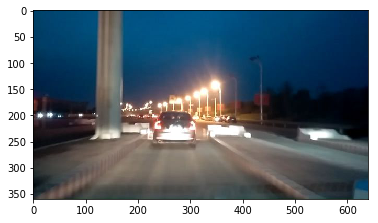

In [3]:
image_path = './training/60134.jpg'
img = cv2.imread(image_path)
# img's format is BGR 

def show_image(img):
    image = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
    plot.imshow(image)
    plot.show()

show_image(img)

In [22]:
annotations = {}
with open('training/label.idl') as f:
    lines = f.read().splitlines()
    for line in lines:
        annotation = json.loads(line)
        annotations.update(annotation)

[[105.33312000000001, 179.33328, 172.66624000000002, 217.16676, 1], [267.16672, 160.49988, 478.33344, 323.49996000000004, 1], [424.99968, 169.66656, 515.50016, 225.66672, 1], [522.1664, 155.49984, 638.49984, 275.50008, 1], [317.00032, 148.5, 396.25024, 232.49988, 1]]


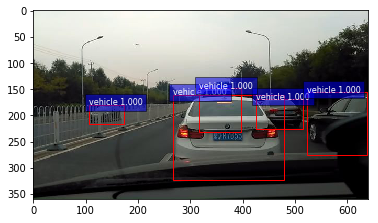

The box is [[105.33312000000001, 179.33328, 172.66624000000002, 217.16676, 1], [267.16672, 160.49988, 478.33344, 323.49996000000004, 1], [424.99968, 169.66656, 515.50016, 225.66672, 1], [522.1664, 155.49984, 638.49984, 275.50008, 1], [317.00032, 148.5, 396.25024, 232.49988, 1]]


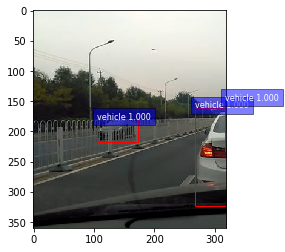

The box is [[105.33312000000001, 179.33328, 172.66624000000002, 217.16676, 1], [267.16672, 160.49988, 320, 323.49996000000004, 1], [317.00032, 148.5, 320, 232.49988, 1]]


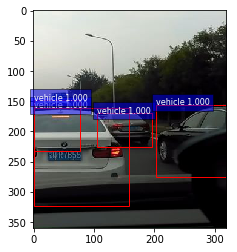

The box is [[0, 160.49988, 158.33344, 323.49996000000004, 1], [104.99968000000001, 169.66656, 195.50016000000005, 225.66672, 1], [202.16639999999995, 155.49984, 318.49983999999995, 275.50008, 1], [0, 148.5, 76.25024000000002, 232.49988, 1]]


In [26]:
import matplotlib.pyplot as plot
import matplotlib.patches as patches

# Add split
def split():
    from PIL import Image, ImageOps
    imgloc = "70064.jpg"
    image = Image.open('./training/'+imgloc)
    
    image_size = {'width': 640, 'height': 360}
    notations = annotations[imgloc]
    print notations
    draw(image, notations)
    new_images = image_split_middle(image, notations, image_size)
    
    draw(new_images[0][0], new_images[0][1])
    draw(new_images[1][0], new_images[1][1])
    
def draw(img, box):
    CLASSES = {1:"vehicle", 2:"pedestrian", 3:"cyclist", 20:"traffic lights"}
    # Create figure and axes
    fig,ax = plot.subplots(1)
    ax.imshow(img)
    for eachbox in box:
        xmin, ymin, xmax, ymax,cls = eachbox 
    
        # Create a Rectangle patch, bottom left, width, height
        rect = patches.Rectangle((xmin,ymin),xmax-xmin,ymax-ymin,linewidth=1,edgecolor='r',facecolor='none', label=CLASSES[cls])

        # Add the patch to the Axes
        ax.add_patch(rect)

        plot.gca().text(xmin, ymin,
                        '{:s} {:.3f}'.format(CLASSES[cls], 1.0),
                        bbox=dict(facecolor='blue', alpha=0.5),
                        fontsize=8, color='white')
    plot.show()
    print "The box is {}".format(box)
    
def image_split_middle(image, org_coordinate, image_size):
    left_image = image.crop((0,0,image_size['width']/2,image_size['height']))
    right_image = image.crop((image_size['width']/2,0, image_size['width'],image_size['height']))
    new_coordinate_left, new_coordinate_right = coordinate_split(org_coordinate, image_size)
    return [[left_image, new_coordinate_left], [right_image, new_coordinate_right]]
    
def coordinate_split(org_cords, image_size):
    """
    split the notation coordinate from original to left half and right half
    :param image_size: original image size, Format {'width': 640, 'height':360}
    :param org_cords: Format of coordinate [[top_left_x, top_left_y, bottom_right_x, bottom_right_y, category],]
    :return: Transferred coordinates with same Format as input
    """
    new_cords = []
    new_cords_left = []
    new_cords_right = []
    middle = image_size['width']/2
    for cord in org_cords:
        if cord[0]<=middle<=cord[2]:
            new_cords_left.append([cord[0],cord[1], middle, cord[3], cord[4]])
            new_cords_right.append([0, cord[1], cord[2]-middle, cord[3], cord[4]])
        # all in left
        elif cord[2]<=middle:
            new_cords_left.append(cord)
        # all in right
        else:
            new_cords_right.append([cord[0]-middle, cord[1], cord[2]-middle, cord[3], cord[4]])   

    return [new_cords_left, new_cords_right]

split()

In [ ]:
import matplotlib.pyplot as plt
import matplotlib.patches as patches
import json
import operator
import os
from os import listdir, getcwd
from os.path import join

def convert_annotation(image_id, boxes):
    CLASSES = {1:0, 2:1, 3:2, 20:3}
    WIDTH = 640
    HEIGHT = 360
    out_file = open('all/%s.txt'%(image_id), 'w')
    for box in v:
        xmin, ymin, xmax, ymax,cls = box
        x1 = xmin
        y1 = ymin
        x2 = xmax
        y2 = ymax
        dw = 1./WIDTH
        dh = 1./HEIGHT
        cx = (x2+x1)/2.*dw
        cy = (y2+y1)/2.*dh
        w = (x2-x1)*dw
        h = (y2-y1)*dh
        out_file.write(str(CLASSES[cls]) + " " + " ".join([str(a) for a in [cx, cy, w, h]]) + '\n')
    out_file.close()

wd = getcwd()
with open('all/all_label.idl') as f:
    #if not os.path.exists('training/'):
    #    os.makedirs('training/')
    
    lines = f.read().splitlines()
    annotations = {}
    for line in lines:
        annotation = json.loads(line)
        annotations.update(annotation) 
    imglist = annotations.keys()
    training_size = int(len(imglist)*.5)
    i = 0
    train_file = open("all/train.txt", 'w')
    val_file = open("all/val.txt", 'w')
    for k,v in annotations.items():
        i += 1
        image_id = k.split('.')[0]
        
        if i < training_size:
            train_file.write('%s/all/%s.jpg\n'%(wd, image_id))
        else:
            val_file.write('%s/all/%s.jpg\n'%(wd, image_id))
        convert_annotation(image_id, v)
        #if i == 3:
        #    break
    train_file.close()
    val_file.close()
WIDTH = 640
HEIGHT = 360
def draw(imgfile, box):
    CLASSES = {0:"vehicle", 1:"pedestrian", 2:"cyclist", 3:"traffic lights"}
    img = plt.imread("{}".format(imgfile))
    # Create figure and axes
    fig,ax = plt.subplots(1)
    ax.imshow(img)
    for eachbox in box:
        xmin, ymin, xmax, ymax,cls = eachbox 
    
        # Create a Rectangle patch, bottom left, width, height
        rect = patches.Rectangle((xmin,ymin),xmax-xmin,ymax-ymin,linewidth=1,edgecolor='r',facecolor='none', label=CLASSES[cls])

        # Add the patch to the Axes
        ax.add_patch(rect)

        plt.gca().text(xmin, ymin,
                        '{:s} {:.3f}'.format(CLASSES[cls], 1.0),
                        bbox=dict(facecolor='blue', alpha=0.5),
                        fontsize=8, color='white')
    plt.show()
    print "The box is {}".format(box)
    print "image size is {}".format(img.shape)
# double check with one file
with open('all/train.txt', 'r') as f:
    # get a viusalization 
    lines = f.read().splitlines()
    imgfile = lines[2]
    annotation_file = "training/"+imgfile.split('/')[-1].split(".")[0] + ".txt"
    annotation = open(annotation_file, 'r')
    annotation_lines = annotation.read().splitlines()
    box = []
    for line in annotation_lines:
        cls, cx,cy,w,h = [float(a) for a in line.split()]
        cls = int(cls)
        dw = 1./WIDTH
        dh = 1./HEIGHT
        xmin = (cx-w/2.)/dw
        xmax = (cx+w/2.)/dw
        ymin = (cy-h/2.)/dh
        ymax = (cy+h/2.)/dh
        box.append([xmin, ymin, xmax, ymax, cls])
    draw(imgfile, box)